<a href="https://colab.research.google.com/github/jaykay4403/Bayesian-ML/blob/main/jmk2dj_assignment_1_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# James Kanski - jmk2dj - June 20, 2022 - DS6050 - Deep Learning

# Assignment: Benchmarking Neural Nets with the XOR Problem

### DS 6050 - School of Data Science - University of Virginia
In this assignment, you will implement your own neural networks to classify non-linear data from the XOR dataset. For deliverables, you must write code in Python/Tensorflow and submit **this** Jupyter Notebook file (.ipynb) to earn a total of 70 pts. Note that you must save your Notebook filename under this format: **yourUvaUserId_assignment_1_ann.ipynb**.



In [ ]:
# You might want to use the following packages
import numpy as np
import os
#%tensorflow_version 2.x
import tensorflow as tf

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial

---
## 1. THE DATASET AND VISUALIZATION

We will use the non-linear toy data called the XOR dataset. You may use the code snippet below to generate the `train / validate / test` sets. Feel free to change the number of samples, and noise level. To keep the ratio between the sets consistent, please do not change the test_size and random_state parameters.



(720, 2)
(200, 2)
(80, 2)


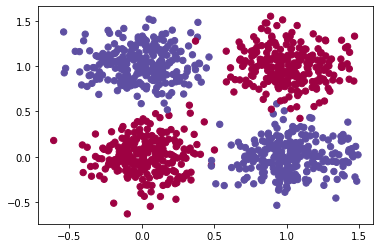

In [ ]:
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers,labels):
        points = np.random.normal(loc=center,scale=0.2,size=(n_points//4,2))
        points_labels = np.hstack((points,label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data,points_labels))
    return (data[:,[0,1]],data[:,2])


X, y = make_xor(1000)
y=y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.1, random_state=49) 
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)


---
## 2. TRAIN A SIMPLE ANN FOR CLASSIFICATION TASK

Use the standard libarary of Neural Net on the training data, and then test the classifier on the test data. You will create a simple ANN with 3 layers: an Input Layer, a Hidden Layer and an Output Layer. For each layer, you can specify the number of nodes appropriate for the XOR problem. Also, feel free to tune the network as you see fit. You have to report the accuracy of the network on the validation set.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.core import Dense
from tensorflow.keras import layers #allows us to create a 'stack' of layers


my_model = keras.Sequential(
    [
     #keras.layers.Dense(2, activation='relu', input_shape=(None, 2), name = 'input'),
     keras.layers.Dense(2, activation='relu', 
                        input_dim=(2), name = 'input'),
     keras.layers.Dense(2, activation='relu', name = 'hidden_1'),
     keras.layers.Dense(2, activation='sigmoid', name = 'output')
     ])

#optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.01, rho=0.9, momentum=0)

# Use Sparse Categorical Cross Entropy loss function for classification with
# with 2 or more classes where labels are intergers

my_model.compile(loss="SparseCategoricalCrossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


# see: https://keras.io/guides/sequential_model/
# see: https://learning.oreilly.com/library/view/applied-deep-learning/9781484280201/html/463356_2_En_2_Chapter.xhtml#Sec17
# see: https://neptune.ai/blog/keras-loss-functions
# see: https://datascience.stackexchange.com/questions/85579/confused-between-optimizer-and-loss-function
# see: https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer#:~:text=It%20is%20generally%20recommend%20to,first%20layer%20after%20the%20InputLayer%20
# see: https://faroit.com/keras-docs/1.0.5/getting-started/sequential-model-guide/

In [ ]:
EPOCHS = 1000
history = my_model.fit(
    X_train, y_train, epochs = EPOCHS, verbose = 0
)

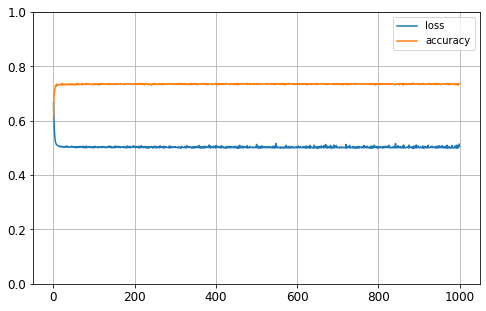

In [ ]:
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

In [ ]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 2)                 6         
                                                                 
 hidden_1 (Dense)            (None, 2)                 6         
                                                                 
 output (Dense)              (None, 2)                 6         
                                                                 
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


- - -
## 3. IMPLEMENTING YOUR OWN SIMPLE NEURAL NETWORK

Now that you see how the standard library ANN performs on the XOR dataset, you will attempt to implement your own version of the neural network. To help you, a template has been created including the backpropagation. Essensially, you will get the backward gradients for free. However, please note that the backprop implementation assume usage of tanh activation for the hidden layer and softmax for the output layer. There are some subtasks which you need to implement in order to get the network to work properly.

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax
np.set_printoptions(precision=7) 

class MyNeuralNet(BaseEstimator):
    """Your implementation of a simple neural network"""

    def __init__ (self, n0, n1, n2, alpha=0.01):

      ## see my comments after ## in @param below...
        """
        @param: n0: Number of nodes in the input layer ## same as d_in in M2.6.1
        @param: n1: Number of nodes in the hidden layer ## this is new
        @param: n2: Number of nodes in the output  ## same as d_out in M2.6.1
        @param: alpha: The Learning Rate
        """

        # SUBTASK 1: Initialize the parameters to random values.
        ## completed using # of nodes based on def__init__ in 2.6.1

        np.random.seed(42)
        self.W1 = np.random.normal(loc=0, scale=0.01, size=(n1, n0)) 
        self.W2 = np.random.normal(loc=0, scale=0.01, size=(n2, n1))
       

        # Configure the learning rate
        self.alpha = alpha
        # One-hot encoder for labels
        self.encoder = OneHotEncoder(sparse=False)
        
    def forward_pass(self, X):
        """
        Pass the signal forward through the layers.
        @param: X: feature
        @return: A1: saved value of the output of the hidden layer
        @return: A2: activated return value of the output layer.
        """
        # SUBTASK 2: Implement Forward propagation.
        # Note: that you must implement tanh activation for the hiden layer 
        # and softmax for the output layer

        ## for tahn, see: https://www.geeksforgeeks.org/numpy-tanh-python/#:~:text=The%20numpy.,sinh(x)%20%2F%20np
        ## for softmax, see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.softmax.html 

        ## Moved bias to forward_pass to account for shape of current dataset (train, validate, test)
        ## Otherwise I found a problem with the L1+ b's being one dataset behind 
        self.b1 = np.random.normal(loc=0, scale=0.01, size=(n1, X.shape[1]))
        self.b2 = np.random.normal(loc=0, scale=0.01, size=(n2, X.shape[1]))
        
        Z1 = np.matmul(self.W1, X) + self.b1

        ## tahn: a = tahn(z) = (e^z - e^-z) / (e^z + e^-z)  M2.4 pdf, p 21
        A1 = np.tanh(Z1)

        Z2 = np.matmul(self.W2, A1) + self.b2

        ## softmax(x) = np.exp(x)/sum(np.exp(x))
        A2 = softmax(Z2) 

        return A1, A2 


    def loss(self, X, y):
        """
        Evaluate the total loss on the dataset
        @param: X: features
        @param: y: labels
        @return: L: the loss value
        """
        

        # SUBTASK 3: Calculate the loss using Cross-Entropy
        # You will need to return the average loss on the data
        # Hint: Use A2 to calculate the loss
        A1, A2 = self.forward_pass(X)

        ## multi-class cross-entropy: https://numpy-ml.readthedocs.io/en/latest/numpy_ml.neural_nets.losses.html
        ## MC cross-entropy calc: L = np.sum(Y * np.log(A2))/m
        ## binary cross-entropy: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html
        ## see: https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
        
        # Another Hint: First, you may want to convert the label y into a one-hot vector
        m = y.shape[0]
        Y = self.one_hot(y)

        ## binary cross-entropy calculation
        L = -(Y * np.log(A2) - (1 - Y) * np.log(1-A2))
        #L = np.sum(Y * np.log(A2))/m
        
        return L
        

    def backward_pass(self, A1, A2, X, y):
        """
        @param: X: feature
        @param: y: label
        @param: A1: saved value of the output of the hidden layer
        @param: a2: activated return value of the output layer.

        @return: dW1: the loss gradient of W1
        @return: db1: the loss gradient of b1
        @return: dW2: the loss gradient of W2
        @return: db2: the loss gradient of b2
        """

        # You DO NOT CHANGE this function, ...
        # unless you are advanced and want to use different activation function for your forward pass
        # This is an elegant partial derivative of cross entropy with softmax
        # Ref document: https://deepnotes.io/softmax-crossentropy
        m   = y.shape[0]
        dZ2 = A2 - self.one_hot(y) 
        dW2 = np.dot(dZ2, A1.T)/m
        db2 = np.sum(dZ2, axis=1, keepdims=True)/m
        dZ1 = np.multiply( np.dot( self.W2.T, dZ2), 1-np.power( A1, 2))
        dW1 = np.dot(dZ1, X.T)/m
        db1 = np.sum(dZ1, axis=1, keepdims=True)/m

        return dW1, db1, dW2, db2


    def fit(self, X, y , epochs, X_val, Y_val):
        """
        Learns parameters for the neural network and returns the model.
        
        @param: X: the training feature
        @param: y: the train label
        @param: epochs: Number of passes through the training data for gradient descent
        @param: X_val: the feature of validation set
        @param: y_val: the label of validation set
        """

        # Input checks: X and X_val needs to be in the form of n0 x m
        if (X.shape[0] > X.shape[1]): X = X.T
        if (X_val.shape[0] > X_val.shape[1]): X_val = X_val.T

        # Gradient descent
        for i in range(0, epochs):
            
            # SUBTASK 4: Compute the forward, backward, and gradient descent parameter update
            # Step 1: Forward pass
            A1, A2 = self.forward_pass(X)
            
            # Step 2: Backward pass
            dW1, db1, dW2, db2 = self.backward_pass(A1, A2, X, y)

            # Step 3: Gradient Descent 
            ## Update the model using gradient descent - insert negative & learning_rate
            self.W1 -= self.alpha*dW1
            self.b1 -= self.alpha*db1
            self.W2 -= self.alpha*dW2
            self.b2 -= self.alpha*db2

            # Print the loss and validation accuracy every 10 epochs.
            # if i % 10 == 0:
            #    print("Epoch %i/%i - loss: %f - accuracy: %f - val_loss: %f - val_accuracy: %f" 
            #          %(i,epochs, self.loss(X, y), self.evaluate(X, y),
            #            self.loss(X_val, y_val), self.evaluate(X_val,y_val)))

            
    def predict(self, X):
        """
        Predict label vector y
        """
        # check X for the form of n0 x m
        if (X.shape[0] > X.shape[1]): X = X.T
        
        # SUBTASK 5: Implement the prediction process. 
        # Hint: It should include a forward pass, and then use the class with higher probability.

        A1, A2 = self.forward_pass(X)
        t = A2.T
        t_list = [] # create list to store higher probability class
        
        # Select class with higher probability
        for i in range(0,len(t)):
            if t[i,:][0] > t[i,:][1]:
                t_list.append(0)
            else:
                t_list.append(1)

        y_hat = np.array(t_list) # convert list to array

        return y_hat


    def evaluate(self, X, y):
        """
        Evaluate the accuracy of the model
        """
        m = y.shape[0]
        y_hat = self.predict(X)
        correct_y = (y_hat == y).astype(int)

        return sum(correct_y)/m


    def one_hot(self, y):
        """
        Utility function: Convert a label vector to one-hot vector
        """
        Y = self.encoder.fit_transform(y.reshape(len(y),1))  
        return Y.T # Transpose to get into same shape 1 x m


    def plot_decision_boundary(self, X, y):
        """
        Utility Function: Plot a decision boundary for visualization purpose.
        If you don't fully understand this function don't worry, it just generates the contour plot below.
        """
        # Set min and max values and give it some padding
        x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
        y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
        h = 0.01
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole gid
        data_grid= np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(data_grid)
        Z = Z.reshape(xx.shape)

        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)        

---
## 4. REFLECT ON THE COMPARISON BETWEEN YOUR IMPLEMENTATION TO THE STANDARD LIBRARY
Now that you have implemented your own Neural Net class, let's use it! Create at least 3 instances of your Neural Net class, each with a different number of nodes in the hiden layer, tune it with the appropriate learning rate and number of iteration. You will test their performance in the Xor dataset and report the test accuracy metrics for each instance of your neural network.

Based on the test accuracy, compare your models with the standard library version. 

Accuracy on the test set is  0.65


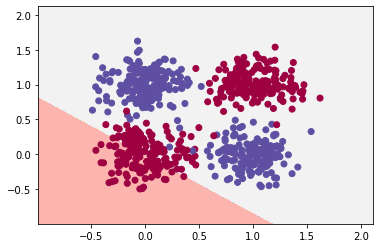

In [ ]:
# MODEL 1 here
n0 = 2 # input layer dimensionality
n1 = 10 # hidden layer dimensionality
n2 = 2 # output layer dimensionality
alpha = .05 # learning rate for gradient descent
epochs = 2000 # number of iteration/epochs

# Build a model with 3 layers
myModel1 = MyNeuralNet(n0, n1, n2, alpha);
myModel1.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

# Plot the decision boundary
myModel1.plot_decision_boundary(X_train, y_train)

Accuracy on the test set is  0.515


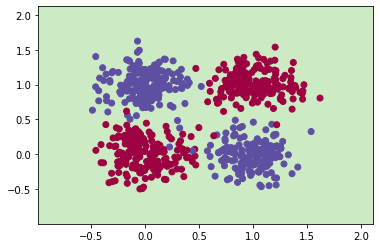

In [ ]:
# MODEL 2 here
n0 = 2 # input layer dimensionality
n1 = 20 # hidden layer dimensionality
n2 = 2 # output layer dimensionality
alpha = 1 # learning rate for gradient descent
epochs = 2000 # number of iteration/epochs

# Build a model with 3 layers
myModel1 = MyNeuralNet(n0, n1, n2, alpha);
myModel1.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

# Plot the decision boundary
myModel1.plot_decision_boundary(X_train, y_train)

Accuracy on the test set is  0.555


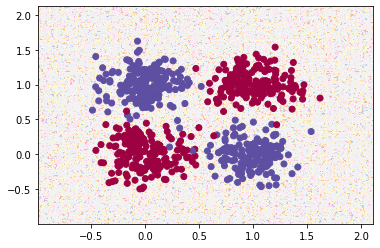

In [ ]:
# MODEL 3 here
n0 = 2 # input layer dimensionality
n1 = 1 # hidden layer dimensionality
n2 = 2 # output layer dimensionality
alpha = .0001 # learning rate for gradient descent
epochs = 1000 # number of iteration/epochs

# Build a model with 3 layers
myModel1 = MyNeuralNet(n0, n1, n2, alpha);
myModel1.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

# Plot the decision boundary
myModel1.plot_decision_boundary(X_train, y_train)

In [ ]:
# COMPARISONS OF THESE MODELS WITH THE STANDARD LIBRARY MODEL IN TASK 2

## The keras model produced accuracy of 0.714.

## The three runs of the by-scratch model yielded accuracies of: 0.65, 0.515 and 0.555.

## The automated model was model accurate as expects because of the streamlined coding
## and built-in optimzation.

## Reflection
Our network performed well. Similar to the experience of others, we spent quite a lot of time of time experimenting with different activation functions and learning rates. The hidden noded & learning rates seemed to center around certain values (not surprisinglyly!), but the range vaired dramaticallt depending on the number of hidden nodes.

I found #3 to be extremely challenging. In particular, a bug crept into my code related to the matrix transformations between the layers. This 'debugging' effort forced me to do a deep dive into the mechanics of certain parts of the ANN, and it DEFINITELY reinforced and brought to life the module work and the class discussions.

---
# Get Help?
In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lecture slides on Module 2
 * Talk to the TA, they are available and there to help you during office hour.
 * Come talk to me or email me <soa2wg@virginia.edu> with subject starting "DS 6050 Assignment 1:...".

Part of the codes used in this assignment is modified from Konstantinos Kitsios under the 3-Clause BSD License. Best of luck and have fun!